In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [3]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        max_len=5000,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=max_len
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
device

'cuda'

In [5]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader):
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [6]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        
        # negative likelihood and total words to compute perplexity
        total_nll = 0
        total_words = 0
        
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
            
            # Compute the negative log-likelihood of the test data
            pred_norm = torch.softmax(pred, dim=-1)
            nll = -torch.log(pred_norm.permute(0, 2, 1).gather(2, y_expected.unsqueeze(2)).squeeze(2)).sum()
            total_nll += nll
            total_words += len(y_expected)

        perplexity = torch.exp(total_nll / total_words)
        
    return total_loss / len(dataloader), perplexity

In [7]:
def predict(model, input_sequence, max_length=1024, SOS_token=121, EOS_token=122):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

def predict_temp(model, input_sequence, max_length=1024, SOS_token=121, EOS_token=122, temperature=0.8):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        # Define temperature
        temp = temperature

        # Apply softmax with temperature scaling
        log_probs = F.log_softmax(pred / temp, dim=-1)[0]

        # Sample tokens from the probability distribution
        token_ids = torch.multinomial(torch.exp(log_probs), num_samples=1)
        next_item = token_ids.item()
        
        #### old version ####
        # next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        #####################
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

In [8]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs, temperature=0.8, test_sequence=[0], out="all"):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list, perplexity_list = [], [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss, perplexity = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        perplexity_list += [perplexity]
        
        if (out == "all" or (epoch+1) % 10 == 0 or epoch == epochs-1) and out != "none":
            
            test_seq = torch.tensor([test_sequence], dtype=torch.long, device=device)
            pred = predict(model, test_seq, max_length=64)
            pred_temp = predict_temp(model, test_seq, max_length=64, temperature=temperature)
        
            print(f"Training loss: {train_loss:.4f}")
            print(f"Validation loss: {validation_loss:.4f}")
            print(f"Perplexity: {perplexity:.4f}")
            print("Predicted sequence: ", pred)
            print("Predicted sequence (temperature): ", pred_temp)

        print()
        
    return train_loss_list, validation_loss_list, perplexity_list


In [9]:
NOTE_TYPES_following = {
    "start": ["pos"],
    "start-pos": ["pitch", "ptriole"],
    "start-pos-ptriole": ["pitch"],
    "start-pos-pitch": ["duration"],
    "start-pos-ptriole-pitch": ["duration"],
    "start-pos-pitch-duration": ["dtriole"],
    "start-pos-pitch-duration-dtriole": [],
    "start-pos-ptriole-pitch-duration": ["dtriole"],
    "start-pos-ptriole-pitch-duration-dtriole": [],
}

def analyze_token_sequence(seq):
    counts = {note_type: 0 for note_type in NOTE_TYPES_following}
    current_note_type = "start"

    for token in seq:

        if token_type(token) in NOTE_TYPES_following[current_note_type]:
            current_note_type += "-" + token_type(token)
        else:
            counts[current_note_type] += 1
            if token_type(token) == "pos":
                current_note_type = "start-pos"
            else:
                current_note_type = "start"
    
    counts[current_note_type] += 1
    return counts

def token_type(token):
    if token in range(102, 118):
        return "pos"
    elif token in range(1, 37):
        return "pitch"
    elif token in range(118, 120):
        return "ptriole"
    elif token in range(37, 101):
        return "duration"
    elif token == 101:
        return "dtriole"
    elif token == 0:
        return "Bar"
    elif token in range(120, 123):
        return "Bar"
    else:
        raise ValueError("Invalid token: {}".format(token))

## Song Data

In [10]:
# 119 tokens
# <PAD> 120
# <SOS> 121
# <EOS> 122
PAD = 120
SOS = 121
EOS = 122

In [11]:
with open('data.json', 'r') as fp:
    data = json.load(fp)

token_list = []
for song in data:
    token_list.append(data[song])

len(token_list)

803

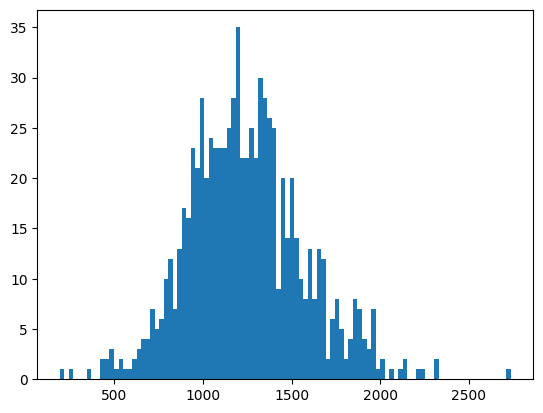

In [12]:
lengths = [len(song) for song in token_list]
plt.hist(lengths, bins=100)
plt.show()

In [13]:
def batchify_data_max_token_length(data, batch_size, max_token_lengths, padding=True, padding_token=PAD, start_token=SOS, end_token=EOS):
    batches = []
    for idx in range(0, len(data), batch_size): # HIER GEHEN DIE LETZTEN 3 SONGS VERLOREN
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            if padding:
                for seq_idx in range(batch_size):
                    # when song length smaller add <PAD> else cut tokens
                    if len(data[idx + seq_idx]) < max_token_lengths-2:
                        remaining_length = max_token_lengths - 2 - len(data[idx + seq_idx])
                        data[idx + seq_idx] = [start_token] + data[idx + seq_idx] + [end_token] + [padding_token] * remaining_length
                    else:
                        data[idx + seq_idx] = [start_token] + data[idx + seq_idx][:max_token_lengths-2] + [end_token]
            # double token seq as in and output
            data[idx : idx + batch_size] = [[token_seq, token_seq] for token_seq in data[idx : idx + batch_size]]
            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches

In [14]:
def slice_data(data, window_size):
    sliced_data = []
    for d in data:
        for i in range(0, len(d) - window_size + 1, window_size):
            window = d[i:i+window_size]
            sliced_data.append(window)
    return sliced_data

In [15]:
DIM_MODEL = 128
NHEAD = 4
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DROPOUT = 0
LEARNING_RATE = 0.001
MAX_TOKEN_LENGTH = 128
EPOCHS = 200
BATCH_SIZE = 4

In [16]:
hyperparameters = {
    "DIM_MODEL": DIM_MODEL,
    "NHEAD": NHEAD,
    "NUM_ENCODER_LAYERS": NUM_ENCODER_LAYERS,
    "NUM_DECODER_LAYERS": NUM_DECODER_LAYERS,
    "DROPOUT": DROPOUT,
    "LEARNING_RATE": LEARNING_RATE,
    "MAX_TOKEN_LENGTH": MAX_TOKEN_LENGTH,
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
}

In [17]:
dic = {"model1": hyperparameters, "model2": hyperparameters}
df = pd.DataFrame(dic)
df

,model1,model2
DIM_MODEL,512.000,512.000
NHEAD,8.000,8.000
NUM_ENCODER_LAYERS,12.000,12.000
NUM_DECODER_LAYERS,12.000,12.000
DROPOUT,0.000,0.000
LEARNING_RATE,0.001,0.001
MAX_TOKEN_LENGTH,256.000,256.000
EPOCHS,200.000,200.000
BATCH_SIZE,4.000,4.000


In [18]:
sliced_songs = slice_data(token_list, MAX_TOKEN_LENGTH)
percent_90 = int(len(sliced_songs) * 0.9)

print("data count: ", len(sliced_songs))
print("data 90%:   ", percent_90)

batches_train = batchify_data_max_token_length(
    sliced_songs[:percent_90],
    batch_size=BATCH_SIZE,
    max_token_lengths=MAX_TOKEN_LENGTH
    )
batches_test = batchify_data_max_token_length(
    sliced_songs[percent_90:],
    batch_size=BATCH_SIZE,
    max_token_lengths=MAX_TOKEN_LENGTH
    )

data count:  3492
data 90%:    3142
785 batches of size 4
87 batches of size 4


In [19]:
model = Transformer(
    num_tokens=123,
    dim_model=DIM_MODEL,
    num_heads=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout_p=DROPOUT
).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [20]:
# if loading from checkpoint

checkpoint = torch.load("model_checkpoints/model_8.pt")
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_list = checkpoint['train_loss']
validation_loss_list = checkpoint['val_loss']



In [ ]:
train_loss_list, validation_loss_list, perplexity_list = fit(model, opt, loss_fn, batches_train, batches_test, EPOCHS, out="not_all")

Training and validating model
------------------------- Epoch 1 -------------------------


100%|██████████| 785/785 [02:19<00:00,  5.63it/s]



------------------------- Epoch 2 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 3 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 4 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 5 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 6 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 7 -------------------------


100%|██████████| 785/785 [02:18<00:00,  5.69it/s]



------------------------- Epoch 8 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 9 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 10 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]


Training loss: 1.7548
Validation loss: 1.7757
Perplexity: inf
Predicted sequence:  [121, 0, 107, 8, 8, 8, 0, 107, 101, 0, 107, 8, 40, 0, 107, 8, 40, 0, 108, 8, 40, 108, 8, 40, 108, 8, 40, 0, 107, 8, 40, 0, 107, 8, 40, 108, 8, 40, 0, 107, 13, 40, 108, 8, 40, 108, 8, 40, 108, 8, 40, 108, 8, 40, 108, 8, 40, 108, 8, 40, 108, 8, 40, 108, 13]
Predicted sequence (temperature):  [121, 6, 101, 91, 101, 0, 0, 107, 113, 108, 8, 101, 8, 17, 101, 101, 52, 20, 108, 40, 0, 20, 101, 72, 0, 0, 8, 8, 13, 13, 0, 0, 92, 111, 112, 10, 15, 20, 15, 13, 40, 101, 1, 10, 13, 119, 101, 0, 13, 9, 0, 8, 0, 107, 60, 13, 13, 13, 0, 0, 5, 101, 101, 101, 0]

------------------------- Epoch 11 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 12 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 13 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 14 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 15 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 16 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 17 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 18 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 19 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 20 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]


Training loss: 1.6696
Validation loss: 1.7080
Perplexity: inf
Predicted sequence:  [121, 0, 107, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0, 107, 13, 44, 101, 0]
Predicted sequence (temperature):  [121, 101, 111, 6, 0, 110, 68, 112, 0, 20, 0, 0, 84, 0, 46, 101, 20, 0, 0, 0, 8, 76, 28, 22, 29, 0, 0, 0, 0, 0, 44, 0, 0, 0, 56, 0, 114, 13, 112, 119, 101, 108, 101, 101, 108, 0, 0, 111, 3, 45, 107, 101, 0, 0, 6, 101, 103, 13, 101, 101, 0, 13, 0, 3, 109]

------------------------- Epoch 21 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 22 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 23 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 24 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 25 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 26 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 27 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 28 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 29 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 30 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]


Training loss: 1.6059
Validation loss: 1.6554
Perplexity: inf
Predicted sequence:  [121, 0, 107, 101, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0, 107, 6, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 101, 0, 107, 117, 12, 13, 8, 0, 13, 101, 108, 101, 3, 108, 0, 101, 5, 15, 0, 28, 119, 0, 0, 116, 111, 111, 84, 108, 0, 0, 13, 107, 108, 112, 0, 82, 0, 74, 108, 101, 56, 0, 101, 108, 0, 0, 0, 116, 101, 0, 0, 118, 0, 0, 0, 24, 0, 101, 0, 0, 101]

------------------------- Epoch 31 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 32 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 33 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 34 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 35 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 36 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 37 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 38 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 39 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 40 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]


Training loss: 1.4725
Validation loss: 1.5271
Perplexity: inf
Predicted sequence:  [121, 0, 0, 0, 107, 0, 107, 0, 108, 0, 0, 107, 6, 0, 107, 6, 0, 0, 107, 6, 0, 0, 107, 6, 0, 0, 107, 6, 0, 107, 6, 0, 0, 107, 6, 0, 0, 107, 6, 0, 0, 107, 6, 0, 107, 6, 0, 0, 107, 6, 0, 0, 107, 6, 0, 0, 107, 6, 0, 107, 6, 0, 0, 107, 6]
Predicted sequence (temperature):  [121, 0, 0, 108, 50, 0, 108, 107, 11, 91, 15, 116, 1, 0, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 0, 0, 0, 116, 3, 0, 26, 0, 119, 118, 0, 0, 6, 101, 0, 0, 0, 20, 0, 0, 0, 16, 84, 10, 0, 0, 0, 0, 0, 0, 53, 0, 0, 0, 101, 0, 0, 101, 6, 111, 0]

------------------------- Epoch 41 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 42 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 43 -------------------------


100%|██████████| 785/785 [02:18<00:00,  5.69it/s]



------------------------- Epoch 44 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 45 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 46 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 47 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 48 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 49 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 50 -------------------------


100%|██████████| 785/785 [02:18<00:00,  5.68it/s]


Training loss: 1.2823
Validation loss: 1.3313
Perplexity: inf
Predicted sequence:  [121, 0, 0, 0, 0, 0, 107, 101, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0, 0, 107, 6, 0, 0]
Predicted sequence (temperature):  [121, 0, 101, 0, 0, 116, 0, 25, 48, 0, 0, 101, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 121, 0, 0, 0, 0, 0, 0, 70, 101, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 46, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0]

------------------------- Epoch 51 -------------------------


100%|██████████| 785/785 [02:18<00:00,  5.68it/s]



------------------------- Epoch 52 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 53 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 54 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 55 -------------------------


100%|██████████| 785/785 [02:12<00:00,  5.91it/s]



------------------------- Epoch 56 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 57 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 58 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 59 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 60 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]


Training loss: 1.1842
Validation loss: 1.2565
Perplexity: inf
Predicted sequence:  [121, 0, 0, 101, 0, 0, 107, 101, 0, 0, 107, 6, 0, 0, 107, 6, 48, 0, 0, 108, 6, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6, 48, 0, 0, 107, 6]
Predicted sequence (temperature):  [121, 0, 101, 0, 0, 0, 0, 0, 0, 107, 0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 101, 0, 12, 0, 101, 0, 0, 60, 0, 0, 0, 0, 101, 0, 6, 0, 25, 101, 0, 101, 99, 101, 0, 101, 107, 0, 0, 13, 0]

------------------------- Epoch 61 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 62 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 63 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 64 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 65 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 66 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 67 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 68 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 69 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 70 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]


Training loss: 1.1268
Validation loss: 1.2155
Perplexity: inf
Predicted sequence:  [121, 0, 0, 0, 108, 0, 101, 0, 101, 0, 0, 107, 6, 48, 0, 0, 0, 107, 6, 48, 0, 0, 0, 107, 6, 48, 0, 0, 0, 107, 6, 48, 0, 0, 0, 107, 6, 60, 0, 0, 0, 107, 6, 60, 0, 0, 0, 107, 6, 60, 0, 0, 0, 107, 6, 60, 0, 0, 116, 119, 8, 60, 0, 0, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 101, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 61, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 13, 0, 101, 0, 0, 0, 26]

------------------------- Epoch 71 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 72 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 73 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 74 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 75 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 76 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 77 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 78 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 79 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 80 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]


Training loss: 1.0725
Validation loss: 1.1792
Perplexity: inf
Predicted sequence:  [121, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 101, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 20, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0]

------------------------- Epoch 81 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 82 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 83 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 84 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 85 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 86 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 87 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 88 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 89 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 90 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]


Training loss: 1.0322
Validation loss: 1.1574
Perplexity: inf
Predicted sequence:  [121, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 101, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 101, 0, 101, 0, 0, 0, 0, 0, 0, 0, 101, 101, 101, 101, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 101, 0, 101, 0]

------------------------- Epoch 91 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 92 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 93 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 94 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 95 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 96 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 97 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 98 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 99 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 100 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]


Training loss: 0.9995
Validation loss: 1.1422
Perplexity: inf
Predicted sequence:  [121, 0, 0, 0, 108, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted sequence (temperature):  [121, 0, 0, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 101]

------------------------- Epoch 101 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 102 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 103 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 104 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 105 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 106 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 107 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 108 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 109 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 110 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]


Training loss: 0.9721
Validation loss: 1.1350
Perplexity: inf
Predicted sequence:  [121, 0, 0, 108, 0, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 13, 101, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0]

------------------------- Epoch 111 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 112 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 113 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 114 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 115 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 116 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 117 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 118 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 119 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 120 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]


Training loss: 0.9477
Validation loss: 1.1285
Perplexity: inf
Predicted sequence:  [121, 0, 0, 108, 0, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

------------------------- Epoch 121 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 122 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 123 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 124 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 125 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 126 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 127 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 128 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.69it/s]



------------------------- Epoch 129 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 130 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]


Training loss: 0.9222
Validation loss: 1.1276
Perplexity: inf
Predicted sequence:  [121, 0, 0, 108, 0, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0]
Predicted sequence (temperature):  [121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 122]

------------------------- Epoch 131 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 132 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 133 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 134 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 135 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.70it/s]



------------------------- Epoch 136 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.72it/s]



------------------------- Epoch 137 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 138 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 139 -------------------------


100%|██████████| 785/785 [02:17<00:00,  5.71it/s]



------------------------- Epoch 140 -------------------------


 32%|███▏      | 255/785 [00:44<01:29,  5.95it/s]

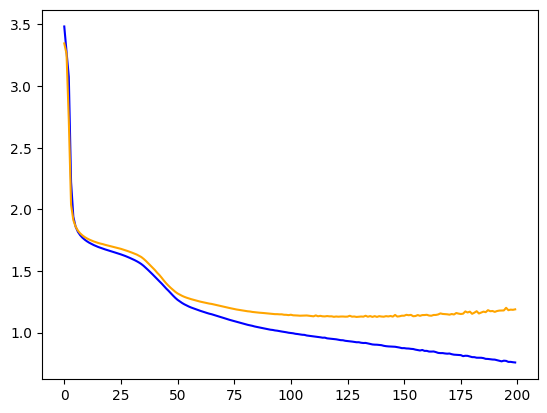

In [21]:
plt.plot(train_loss_list, color="blue")
plt.plot(validation_loss_list, color="orange")
plt.show()

In [22]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[SOS, 0, 104, 17, 38, 105, EOS]], dtype=torch.long, device=device),
    torch.tensor([[SOS, 0, 103, EOS]], dtype=torch.long, device=device)
]
results = []

for idx, example in enumerate(examples):
    result = predict_temp(model, example, max_length=64, temperature=0.8)
    results.append(result)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 104, 17, 38, 105]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [0, 103]
Continuation: [103, 103, 0, 103, 0, 0, 0, 0, 103, 0, 103, 0, 103, 103, 0, 103, 103, 101, 118, 0, 0, 103, 103, 0, 0, 103, 103, 103, 103, 103, 0, 103, 0, 103, 103, 103, 103, 103, 0, 0, 0, 0, 103, 103, 103, 103, 103, 103, 0, 0, 0, 103, 103, 103, 0, 103, 0, 103, 0, 0, 103, 0, 0]



In [26]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[SOS, 0, 104, 17, 38, 105, EOS]], dtype=torch.long, device=device),
    torch.tensor([[SOS, 0, 103, EOS]], dtype=torch.long, device=device)
]
results = []

for idx, example in enumerate(examples):
    result = predict_temp(model, example, max_length=64, temperature=1.2)
    results.append(result)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 104, 17, 38, 105]
Continuation: [0, 111, 0, 0, 118, 76, 0, 0, 0, 54, 0, 24, 0, 0, 0, 0, 101, 0, 111, 0, 81, 105, 0, 0, 20, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 0, 15, 0, 0, 109, 38, 0, 0, 0, 103, 0, 118, 0, 0, 12, 7, 0, 0, 0, 101, 0, 0, 0, 118]

Example 1
Input: [0, 103]
Continuation: [0, 112, 0, 103, 103, 102, 0, 17, 102, 103, 112, 15, 111, 8, 103, 103, 103, 0, 0, 0, 103, 0, 0, 103, 103, 103, 32, 35, 61, 103, 0, 0, 117, 103, 103, 103, 0]



In [27]:
dic = {}
for idx, res in enumerate(results):
    an = analyze_token_sequence(res)
    dic[idx] = an

pd.DataFrame(dic)

,0,1
start,56,10
start-pos,5,17
start-pos-ptriole,0,0
start-pos-pitch,0,3
start-pos-ptriole-pitch,0,0
start-pos-pitch-duration,0,0
start-pos-pitch-duration-dtriole,0,0
start-pos-ptriole-pitch-duration,0,0
start-pos-ptriole-pitch-duration-dtriole,0,0


In [24]:
torch.save({
            'epoch': 200,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': train_loss_list,
            'val_loss': validation_loss_list,
            }, "model_checkpoints/model_9.pt")